In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession

session = SnorkelSession()

In [2]:
from ksnorkel import KSUtils

train_sent, dev_sent, test_sent = KSUtils.split_sentences(session)
print("Amount of sentences: {} train, {} dev and {} test".format(len(train_sent), len(dev_sent), len(test_sent)))

Amount of docs: 9645
Document splitted: 3215 train, 3215 dev and 3215 test
Amount of sentences: 27763 train, 27526 dev and 27823 test


In [3]:
from snorkel.models import Candidate, candidate_subclass
from snorkel.candidates import PretaggedCandidateExtractor

ChemicalGeneInteraction = candidate_subclass('ChemicalGeneInteraction', ['chemical', 'gene'])
candidate_extractor = PretaggedCandidateExtractor(ChemicalGeneInteraction, ['Chemical', 'Gene'])

for k, sents in enumerate([train_sent,dev_sent, test_sent]):  
    candidate_extractor.apply(sents, split=k, clear=True)
    print("Number of candidates:", session.query(ChemicalGeneInteraction).filter(ChemicalGeneInteraction.split == k).count())

Clearing existing...


  0%|          | 101/27763 [00:00<00:28, 978.17it/s]

Running UDF...


100%|██████████| 27763/27763 [00:21<00:00, 1286.49it/s]


Number of candidates: 4297
Clearing existing...


  0%|          | 128/27526 [00:00<00:21, 1272.43it/s]

Running UDF...


100%|██████████| 27526/27526 [00:13<00:00, 2067.33it/s]


Number of candidates: 4337
Clearing existing...


  0%|          | 63/27823 [00:00<00:44, 626.87it/s]

Running UDF...


100%|██████████| 27823/27823 [00:13<00:00, 2105.42it/s]

Number of candidates: 4595


In [4]:
import gzip
import re

ctd_chem_gene_inter = set()
i = 0
with gzip.open('data/CTD_chem_gene_ixns.tsv.gz','r') as f:
    for l in f:
        line = str(l).replace('b\'', '').replace('\\n\'', '').replace('\\r','')
        # skip comments
        if line.startswith('#'):
            continue
        #print(line)
        components = line.split('\\t')    
        
        # add MESH:
        if not components[1].startswith('MESH:'):
            components[1] = "MESH:" + components[1]
            
        chemical = components[1]
        gene = components[4]
        key = frozenset((chemical, gene))
        ctd_chem_gene_inter.add(key)
        i += 1

    
print('{} chemical-gene assocations read from ChG-CTD_chem_gene_ixns'.format(len(ctd_chem_gene_inter)))
#240349
def cand_in_chemical_gene_interactions(c):
    key = frozenset((c.chemical_cid, c.gene_cid))
    if key in ctd_chem_gene_inter:
    #    print(key)
        return 1
    return -1

1044988 chemical-gene assocations read from ChG-CTD_chem_gene_ixns


In [ ]:
from ksnorkel import KSUtils

KSUtils.add_gold_labels_for_candidates(session, ChemicalGeneInteraction, cand_in_chemical_gene_interactions)

Clearing existing gold labels...
Adding gold labels to training candidates...
Labeld 682 positive and 3615 negative samples in train
Adding gold labels to develop candidates...
Labeld 814 positive and 3523 negative samples in dev
Adding gold labels to test candidates...
Labeld 704 positive and 3891 negative samples in test
Finished - commiting to database...
Commit complete!
Labeld 2200 positive and 11029 negative samples


In [ ]:
import re
from snorkel.lf_helpers import (
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B
)




# List to parenthetical
def ltp(x):
    return '(' + '|'.join(x) + ')'



inhibition_samples = ["inhibitors", "inhibition", "auto-inhibition"]


def LF_CG_AB_before_inhibition(c):
    return 1 if (re.search(r'{{A}}.{0,50} ' + '{{B}}.{0,50}' + 'inhibition' , get_tagged_text(c), re.I) or
                re.search(r'{{B}}.{0,50} ' + '{{A}}.{0,50}' + 'inhibition' , get_tagged_text(c), re.I)) else 0
                

def LF_CG_AB_after_inhibition(c):
    return 1 if (rule_regex_search_before_A(c,  ltp(inhibition_samples) + '.{0,100}', 1) and
                  rule_regex_search_before_B(c, ltp(inhibition_samples) + '.{0,100}', 1)) else 0

def LF_CG_A_inhibition_B_far(c):
    return rule_regex_search_btw_AB(c, '.{0,400}' + ltp(inhibition_samples) + '.{0,400}', -1) 

def LF_CG_B_inhibition_A_far(c):
    return rule_regex_search_btw_BA(c, '.{0,400}' + ltp(inhibition_samples) + '.{0,400}', -1)

def LF_CG_A_inhibition_B(c):
    return rule_regex_search_btw_AB(c, '.{0,50}' + ltp(inhibition_samples) + '.{0,50}', 1) 

def LF_CG_B_inhibition_A(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(inhibition_samples) + '.{0,50}', 1)

def LG_CG_inhibition_before_B_near(c):
    return rule_regex_search_before_B(c, ltp(inhibition_samples) + '.{0,50}', 1)
 
def LG_CG_inhibition_before_B_far(c):
    return rule_regex_search_before_B(c, ltp(inhibition_samples) + '.{0,2000}', -1)


inhibits_samples = ["inhibit"]

def LF_CG_A_inhibitis_B(c):
    return rule_regex_search_btw_AB(c, '.{0,50}' + ltp(inhibits_samples) + '.{0,50}', 1) 

inhibited_samples = ["inhibited"]



def LF_CG_B_inhibited_A(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(inhibited_samples) + '.{0,50}', 1) 



def LF_CG_not_inhibited(c):
    sent = c.get_parent()
    if 'not inhib' not in get_tagged_text(c):
        return -1
    return 0
                

    
LFs_DG = [
    LF_CG_AB_before_inhibition,
    LF_CG_AB_after_inhibition,
    LF_CG_A_inhibition_B_far,
    LF_CG_B_inhibition_A_far,
    LF_CG_A_inhibition_B,
    LF_CG_B_inhibition_A,
    LG_CG_inhibition_before_B_near,
    LG_CG_inhibition_before_B_far,
    LF_CG_A_inhibitis_B,
    LF_CG_B_inhibited_A#,  
 #   LF_CG_not_inhibited
]

In [ ]:
import re
from snorkel.lf_helpers import (
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)
# List to parenthetical
def ltp(x):
    return '(' + '|'.join(x) + ')'



inhibition_samples = ["metabolism", "metabolite", "auto-inhibition"]

def LF_GC_A_metabolism_B(c):
    return rule_regex_search_btw_AB(c, '.{0,50}' + ltp(inhibition_samples) + '.{0,50}', 1) 

def LF_GC_B_metabolism_A(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(inhibition_samples) + '.{0,50}', 1)

def LG_GC_metabolism_before_B_near(c):
    return rule_regex_search_before_B(c, ltp(inhibition_samples) + '.{0,50}', 1)
 
def LG_GC_metabolism_before_B_far(c):
    return rule_regex_search_before_B(c, ltp(inhibition_samples) + '.{0,2000}', 1)


inhibits_samples = ["metabolises", "metabolizes"]

def LF_GC_A_metabolis_B(c):
    return rule_regex_search_btw_AB(c, '.{0,50}' + ltp(inhibits_samples) + '.{0,50}', 1) 

inhibited_samples = ["metabolised", "metabolized"]

def LF_GC_A_metabolized_B(c):
    return rule_regex_search_btw_AB(c, '.{0,50}' + ltp(inhibited_samples) + '.{0,50}', 1) 

def LF_GC_B_metabolized_A(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(inhibited_samples) + '.{0,50}', 1) 



def LF_CG_not_metabol(c):
    sent = c.get_parent()
    if 'not metabol' in get_tagged_text(c):
        return -1
    return 0
                
    
def LF_CG_in_CTD_chem_gene(c):
    if cand_in_chemical_gene_interactions(c) == 1:
        return 1
    else:
        return -1


LFs_GC = [
    LF_GC_A_metabolism_B,
    LF_GC_B_metabolism_A,
    LG_GC_metabolism_before_B_near,
    LG_GC_metabolism_before_B_far,
    LF_GC_A_metabolis_B,
    LF_GC_B_metabolized_A,
#    LF_CG_not_metabol,
    LF_CG_in_CTD_chem_gene
]

In [ ]:
LFs_DG.extend(LFs_GC)

In [ ]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs_DG)
%time L_train = labeler.apply(lfs=LFs_DG, parallelism=1)
L_train

L_train.lf_stats(session)

  0%|          | 16/4297 [00:00<00:26, 158.58it/s]

Clearing existing...
Running UDF...


100%|██████████| 4297/4297 [00:17<00:00, 248.71it/s]


CPU times: user 17.3 s, sys: 132 ms, total: 17.4 s
Wall time: 17.4 s


,j,Coverage,Overlaps,Conflicts
LF_CG_AB_before_inhibition,0,0.002560,0.002560,0.001862
LF_CG_AB_after_inhibition,1,0.000000,0.000000,0.000000
LF_CG_A_inhibition_B_far,2,0.005818,0.005818,0.002793
LF_CG_B_inhibition_A_far,3,0.003491,0.003491,0.001629
LF_CG_A_inhibition_B,4,0.001862,0.001862,0.001862
LF_CG_B_inhibition_A,5,0.001164,0.001164,0.001164
LG_CG_inhibition_before_B_near,6,0.000465,0.000465,0.000465
LG_CG_inhibition_before_B_far,7,0.001629,0.001629,0.001629
LF_CG_A_inhibitis_B,8,0.000000,0.000000,0.000000
LF_CG_B_inhibited_A,9,0.000465,0.000465,0.000465


In [ ]:
from snorkel.annotations import load_gold_labels

L_dev = labeler.apply_existing(split=1)
L_test = labeler.apply_existing(split=2)
L_gold_dev = load_gold_labels(session, annotator_name='gold',split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)


  0%|          | 7/4337 [00:00<01:03, 68.59it/s]

Clearing existing...
Running UDF...


  0%|          | 8/4595 [00:00<01:00, 76.23it/s]

Clearing existing...
Running UDF...


100%|██████████| 4595/4595 [00:28<00:00, 160.87it/s]


In [ ]:
from snorkel.learning import GenerativeModel
from snorkel.learning import RandomSearch
from snorkel.learning.structure import DependencySelector


MAX_DEPS = 5

ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
deps = set(list(deps)[0:min(len(deps), MAX_DEPS)])

print("Using {} dependencies".format(len(deps)))



# use random search to optimize the generative model
param_grid = {
    'step_size' : [1e-3, 1e-4, 1e-5, 1e-6],
    'decay'     : [0.9, 0.95],
    'epochs'    : [50,100,150],
    'reg_param' : [1e-3],
}

model_class_params = {'lf_propensity' : False }#, 'deps': deps}

searcher = RandomSearch(GenerativeModel, param_grid, L_train, n=10, model_class_params=model_class_params)
%time gen_model, run_stats = searcher.fit(L_dev, L_gold_dev) #, deps=deps)
run_stats

train_marginals = gen_model.marginals(L_train)

Using 5 dependencies
[1] Testing step_size = 1.00e-05, decay = 9.50e-01, epochs = 150, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 1.0
[GenerativeModel] Model saved as <GenerativeModel_0>.
[GenerativeModel] Model saved as <GenerativeModel_best>.
[2] Testing step_size = 1.00e-04, decay = 9.50e-01, epochs = 50, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 1.0
[3] Testing step_size = 1.00e-05, decay = 9.00e-01, epochs = 100, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 0.9975490196078431
[4] Testing step_size = 1.00e-05, decay = 9.50e-01, epochs = 150, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 1.0
[5] Testing step_size = 1.00e-03, decay = 9.00e-01, epochs = 100, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 1.0
[6] Testing step_size = 1.00e-05, decay = 9.50e-01, epochs = 50, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Sc

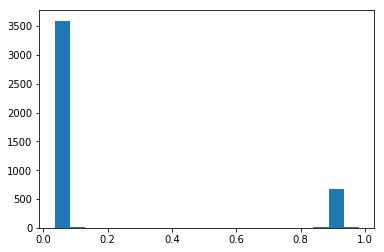

In [ ]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [ ]:
from snorkel.annotations import save_marginals

dev_marginals = gen_model.marginals(L_dev)
_, _, _, _ = gen_model.error_analysis(session, L_dev, L_gold_dev)

%time save_marginals(session, L_train, train_marginals)

Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 1.0
Precision            1.0
Recall               1.0
F1                   1.0
----------------------------------------
TP: 814 | FP: 0 | TN: 3523 | FN: 0

Saved 4297 marginals
CPU times: user 2.8 s, sys: 108 ms, total: 2.91 s
Wall time: 2.91 s


In [ ]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_test, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 1.0
Precision            1.0
Recall               1.0
F1                   1.0
----------------------------------------
TP: 704 | FP: 0 | TN: 3891 | FN: 0



In [ ]:
print("Load all ChemicalGeneInteraction candidates from db...")
train_cands = session.query(ChemicalGeneInteraction).filter(ChemicalGeneInteraction.split == 0).order_by(ChemicalGeneInteraction.id).all()
dev_cands   = session.query(ChemicalGeneInteraction).filter(ChemicalGeneInteraction.split == 1).order_by(ChemicalGeneInteraction.id).all()
test_cands  = session.query(ChemicalGeneInteraction).filter(ChemicalGeneInteraction.split == 2).order_by(ChemicalGeneInteraction.id).all()


all_cands = []
all_cands.extend(train_cands)
all_cands.extend(dev_cands)
all_cands.extend(test_cands)


print("{} {} {}".format(len(train_cands), len(dev_cands), len(test_cands)))
print("Amount of all candidates: {}".format(len(all_cands)))

Load all ChemicalGeneInteraction candidates from db...
4297 4337 4595
Amount of all candidates: 13229


In [ ]:
from snorkel.learning.pytorch import LSTM
from snorkel.annotations import load_gold_labels

#train_kwargs = {
#    'lr':            0.01,
#    'embedding_dim': 75,
#    'hidden_dim':    75,
#    'n_epochs':      100,
#    'dropout':       0.25,
#    'seed':          1701
#}

# Best configuration
train_kwargs = {
    'batch_size':    128,
    'lr':            0.01,
    'embedding_dim': 100,
    'hidden_dim':    100,
    'n_epochs':      100,
    'dropout':       0.0,
    'rebalance':     0.0,
    'seed':          1701
}

lstm = LSTM(n_threads=10)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

p, r, f1 = lstm.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

In [ ]:
#from snorkel.learning import RandomSearch
#from snorkel.learning.pytorch import LSTM

#seed = 12345
#num_model_search = 25

# search over this parameter grid
#param_grid = {}
#param_grid['batch_size'] = [64, 128]
#param_grid['lr']         = [1e-4, 1e-3, 1e-2]
#param_grid['rebalance']  = [0.0,0.25, 0.5]
#param_grid['embedding_dim'] = [75, 100, 125]
#param_grid['hidden_dim'] = [50, 100, 150]
#param_grid['dropout'] = [0, 0.25, 0.5]

#model_class_params = {
#    'n_threads':1
#}


#model_hyperparams = {
#    'n_epochs': 100,
#    'print_freq': 25,
#    'dev_ckpt_delay': 0.5,
#    'X_dev': dev_cands,
#    'Y_dev': L_gold_dev,
#}


#searcher = RandomSearch(LSTM, param_grid, train_cands, train_marginals,
#                        n=num_model_search, seed=seed,
#                        model_class_params=model_class_params,
#                        model_hyperparams=model_hyperparams)

#print("Discriminitive Model Parameter Space (seed={}):".format(seed))
#for i, params in enumerate(searcher.search_space()):
#    print("{} {}".format(i, params))

#disc_model, run_stats = searcher.fit(X_valid=dev_cands, Y_valid=L_gold_dev, n_threads=1)
#lstm = disc_model
#run_stats

Discriminitive Model Parameter Space (seed=12345):
0 (64, 0.01, 0.0, 125, 150, 0.0)
1 (128, 0.001, 0.5, 125, 50, 0.5)
2 (128, 0.01, 0.0, 75, 50, 0.25)
3 (128, 0.01, 0.0, 75, 150, 0.5)
4 (64, 0.001, 0.25, 125, 100, 0.0)
5 (128, 0.0001, 0.5, 125, 50, 0.0)
6 (64, 0.001, 0.0, 100, 150, 0.5)
7 (64, 0.001, 0.5, 75, 100, 0.5)
8 (128, 0.0001, 0.0, 75, 100, 0.0)
9 (64, 0.0001, 0.0, 100, 50, 0.25)
10 (128, 0.0001, 0.5, 75, 100, 0.25)
11 (128, 0.0001, 0.25, 125, 150, 0.0)
12 (64, 0.001, 0.5, 125, 100, 0.25)
13 (128, 0.01, 0.5, 100, 150, 0.25)
14 (128, 0.001, 0.5, 100, 100, 0.0)
15 (64, 0.001, 0.25, 75, 100, 0.25)
16 (128, 0.01, 0.5, 100, 50, 0.25)
17 (128, 0.001, 0.5, 75, 100, 0.5)
18 (128, 0.0001, 0.25, 125, 50, 0.5)
19 (64, 0.001, 0.25, 100, 50, 0.0)
20 (64, 0.01, 0.0, 125, 150, 0.0)
21 (64, 0.0001, 0.5, 75, 150, 0.25)
22 (128, 0.001, 0.0, 100, 50, 0.25)
23 (128, 0.0001, 0.25, 100, 50, 0.0)
24 (128, 0.01, 0.5, 100, 150, 0.25)
[1] Testing batch_size = 128, lr = 1.00e-02, rebalance = 0.00e+00, em

/home/kroll/.conda/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[LSTM] Epoch 1 (10.35s)	Average loss=0.509957	Dev F1=0.25
[LSTM] Epoch 26 (275.02s)	Average loss=0.266228	Dev F1=23.90
[LSTM] Epoch 51 (537.05s)	Average loss=0.263297	Dev F1=23.77
[LSTM] Epoch 76 (797.58s)	Average loss=0.254499	Dev F1=31.42
[LSTM] Model saved as <LSTM>
[LSTM] Epoch 100 (1047.17s)	Average loss=0.250658	Dev F1=31.38
[LSTM] Training done (1052.27s)
[LSTM] Loaded model <LSTM>
[LSTM] F-1 Score: 0.3142458100558659
[LSTM] Model saved as <LSTM_0>
[LSTM] Model saved as <LSTM_best>
[2] Testing batch_size = 64, lr = 1.00e-04, rebalance = 5.00e-01, embedding_dim = 75, hidden_dim = 150, dropout = 0.00e+00
[LSTM] Training model
[LSTM] n_train=1364  #epochs=100  batch size=64
[LSTM] Epoch 1 (4.34s)	Average loss=0.648880	Dev F1=0.00
[LSTM] Epoch 26 (118.36s)	Average loss=0.360500	Dev F1=26.53
[LSTM] Epoch 51 (232.94s)	Average loss=0.301972	Dev F1=30.25
[LSTM] Epoch 76 (345.97s)	Average loss=0.278742	Dev F1=31.14
[LSTM] Model saved as <LSTM>
[LSTM] Epoch 100 (453.43s)	Average loss=0.27

In [23]:
run_stats

,batch_size,lr,rebalance,embedding_dim,hidden_dim,dropout,Prec.,Rec.,F-1
15,128,0.0100,0.00,100,100,0.00,0.411765,0.378378,0.394366
8,64,0.0010,0.00,100,150,0.25,0.443493,0.318182,0.370529
21,64,0.0010,0.00,125,100,0.50,0.266742,0.577396,0.364907
17,128,0.0100,0.25,75,150,0.25,0.300752,0.442260,0.358031
11,128,0.0010,0.25,100,50,0.25,0.283639,0.455774,0.349670
12,128,0.0001,0.00,100,100,0.25,0.238004,0.609337,0.342305
24,128,0.0001,0.00,100,100,0.25,0.235987,0.615479,0.341164
6,64,0.0100,0.25,75,50,0.00,0.298661,0.356265,0.324930
18,64,0.0001,0.00,100,150,0.25,0.260138,0.417690,0.320603
0,128,0.0100,0.00,75,100,0.00,0.364078,0.276413,0.314246


In [24]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.405
Neg. class accuracy: 0.891
Precision            0.403
Recall               0.405
F1                   0.404
----------------------------------------
TP: 285 | FP: 423 | TN: 3468 | FN: 419



In [26]:
lstm.save_marginals(session, all_cands)

Saved 13229 marginals


In [27]:
from snorkel.models.candidate import Marginal
from snorkel.models import Document, Sentence


print("Storing candidate labels into result file...")
amount_of_candidates = session.query(Candidate).count()
print("Amount of candidates: {}".format(amount_of_candidates))
all_sents = []
all_sents.extend(train_sent)
all_sents.extend(dev_sent)
all_sents.extend(test_sent)

header_str = '{}\t{}\t{}\t{}\t{}\t{}\t{}'.format('document_id', 'sentence_id', 'cand_id','chemical_cid', 'chemical_span', 'gene_cid', 'gene_span')
%time KSUtils.save_binary_relation_as_tsv('results/chemical_gene_interaction.tsv', session, all_cands, all_sents, header_str, 'chemical_cid', 'gene_cid')

Storing candidate labels into result file...
Amount of candidates: 13229
Storing candidate labels into result file: results/chemical_gene_interaction.tsv
Amount of candidates: 13229
Load mariginals from db...
Marginals loaded!
Building sentence to document map...
Map built!
Saved 2134 positive predicitions for binary relation!
CPU times: user 1min 26s, sys: 2.63 s, total: 1min 29s
Wall time: 1min 29s


In [25]:
lstm.save("chemical_gene_interaction.lstm")

[LSTM] Model saved as <chemical_gene_interaction.lstm>
